<a href="https://colab.research.google.com/github/sapnil1482/Image-Panorama-Stitching-with-OpenCV/blob/main/Image_Panorama_Stitching_with_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

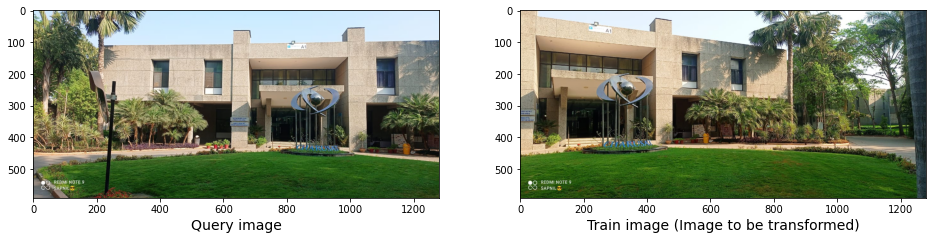

In [20]:
# read images and grayscale transformation 
trainImg = imageio.imread('PATH_OF_IMAGE')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('PATH_OF_IMAGE')

# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (QueryImage,TrainImage) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
QueryImage.imshow(queryImg, cmap="gray")
QueryImage.set_xlabel("Query image", fontsize=14)

TrainImage.imshow(trainImg, cmap="gray")
TrainImage.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [21]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (keyPoints, features) = descriptor.detectAndCompute(image, None)
    
    return (keyPoints, features)

In [22]:
keyPoints_TrainImage, features_TrainImage = detectAndDescribe(trainImg_gray, method=feature_extractor)
keyPoints_QueryImage, features_QueryImage = detectAndDescribe(queryImg_gray, method=feature_extractor)

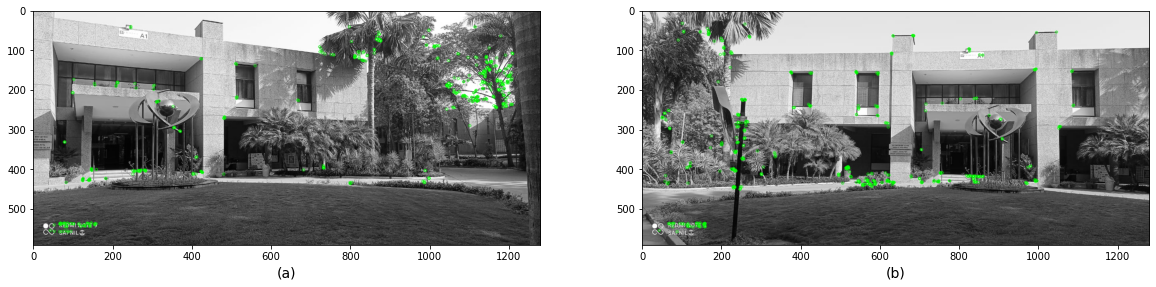

In [23]:
# display the keypoints and features detected on both images
fig, (QueryImage,TrainImage) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
QueryImage.imshow(cv2.drawKeypoints(trainImg_gray,keyPoints_TrainImage,None,color=(0,255,0)))
QueryImage.set_xlabel("(a)", fontsize=14)
TrainImage.imshow(cv2.drawKeypoints(queryImg_gray,keyPoints_QueryImage,None,color=(0,255,0)))
TrainImage.set_xlabel("(b)", fontsize=14)

plt.show()

In [24]:

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [25]:
# This function will reutrn SortedMatch
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [26]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 162


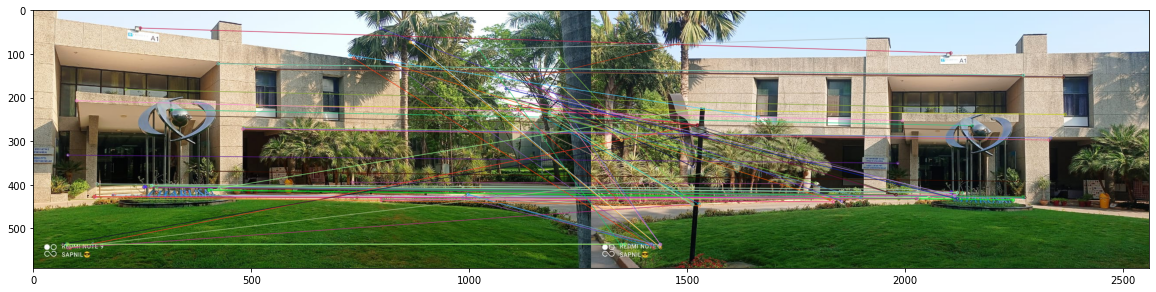

In [27]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(features_TrainImage , features_QueryImage, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,keyPoints_TrainImage,queryImg,keyPoints_QueryImage,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(features_TrainImage , features_QueryImage, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,keyPoints_TrainImage,queryImg,keyPoints_QueryImage,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [28]:
def getHomography(keyPoints_TrainImage, keyPoints_QueryImage, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    keyPoints_TrainImage = np.float32([kp.pt for kp in keyPoints_TrainImage])
    keyPoints_QueryImage = np.float32([kp.pt for kp in keyPoints_QueryImage])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([keyPoints_TrainImage[m.queryIdx] for m in matches])
        ptsB = np.float32([keyPoints_QueryImage[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [29]:

M = getHomography(keyPoints_TrainImage, keyPoints_QueryImage, features_TrainImage, features_QueryImage, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[-1.36168140e-01 -2.93954831e-01  6.99036632e+02]
 [-3.02931727e-01  3.92378400e-01  1.94519180e+02]
 [-7.90542689e-04 -3.41463272e-04  1.00000000e+00]]


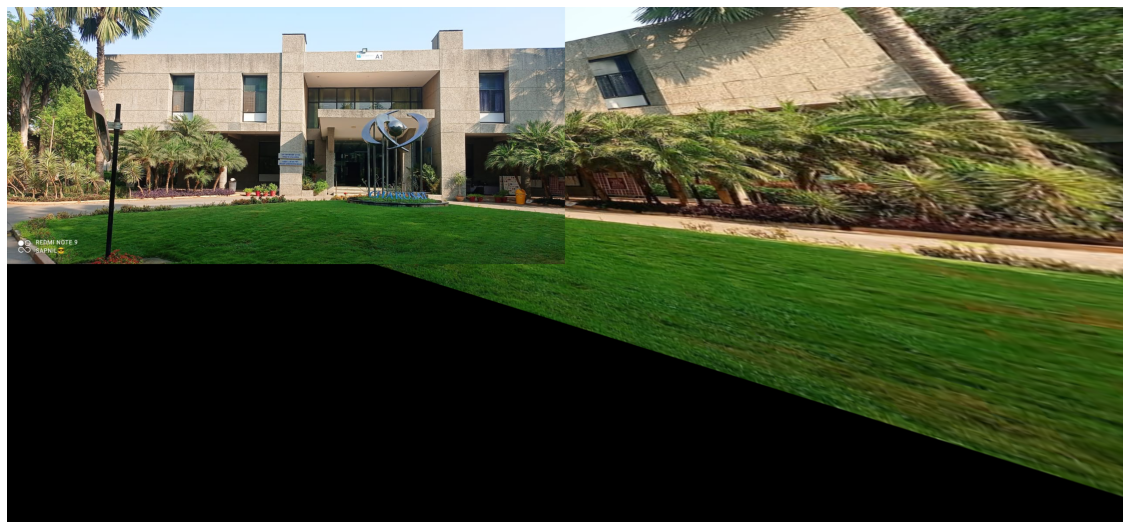

In [30]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

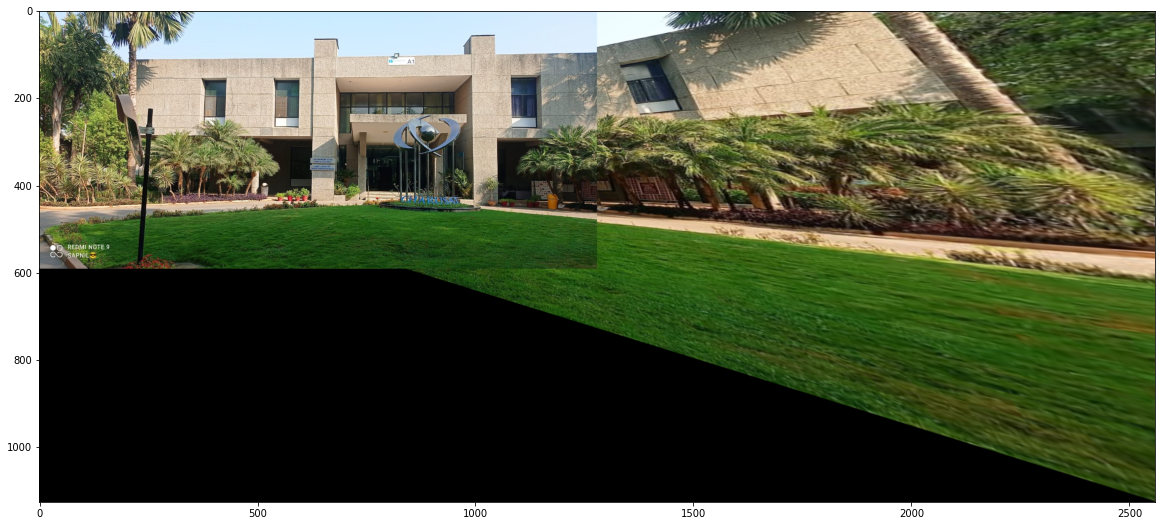

In [31]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)